# The Hunt for Alpha: How We Built a Sharpe-3.27 Intraday Strategy from Scratch



---

This is the story of how we took a dataset of 111 days of intraday tick data, tried everything from GPU-accelerated gradient boosting to Kalman filters, watched it all fail spectacularly, and then found a simple, structural alpha hiding in plain sight one that turned $10,000 into $11,048 with a Sharpe ratio of 3.27, all on purely out-of-sample data.

It wasn't a straight line. It was a journey through overfitting traps, transaction cost nightmares, and the slow, humbling realization that **the best model is often the simplest one.**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os, glob, json, sys
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

TRAIN_DIR = "../train"
OUTPUT_DIR = "output_final"

day_files = sorted(glob.glob(os.path.join(TRAIN_DIR, "*.csv")),
                   key=lambda x: int(Path(x).stem))
print(f"Dataset: {len(day_files)} trading days")
print(f"Day IDs: {[int(Path(f).stem) for f in day_files[:5]]} ... {[int(Path(f).stem) for f in day_files[-5:]]}")

Dataset: 111 trading days
Day IDs: [1, 2, 3, 4, 5] ... [135, 136, 137, 138, 139]


---
## Chapter 1: Understanding What We're Working With

Before writing a single line of trading logic, we needed to understand the beast we were dealing with.

The data was 111 CSV files  one per trading day each containing roughly **20,090 intraday bars** and **281 columns**: 4 price series (P1-P4), a timestamp, and 277 engineered features. Our job: trade P3 profitably, starting with $10,000(assumed portfolio), paying 0.01% transaction cost on every entry and exit.

Simple enough on paper. But the moment we looked at P3's actual volatility, we realized this was going to be much harder than it seemed.

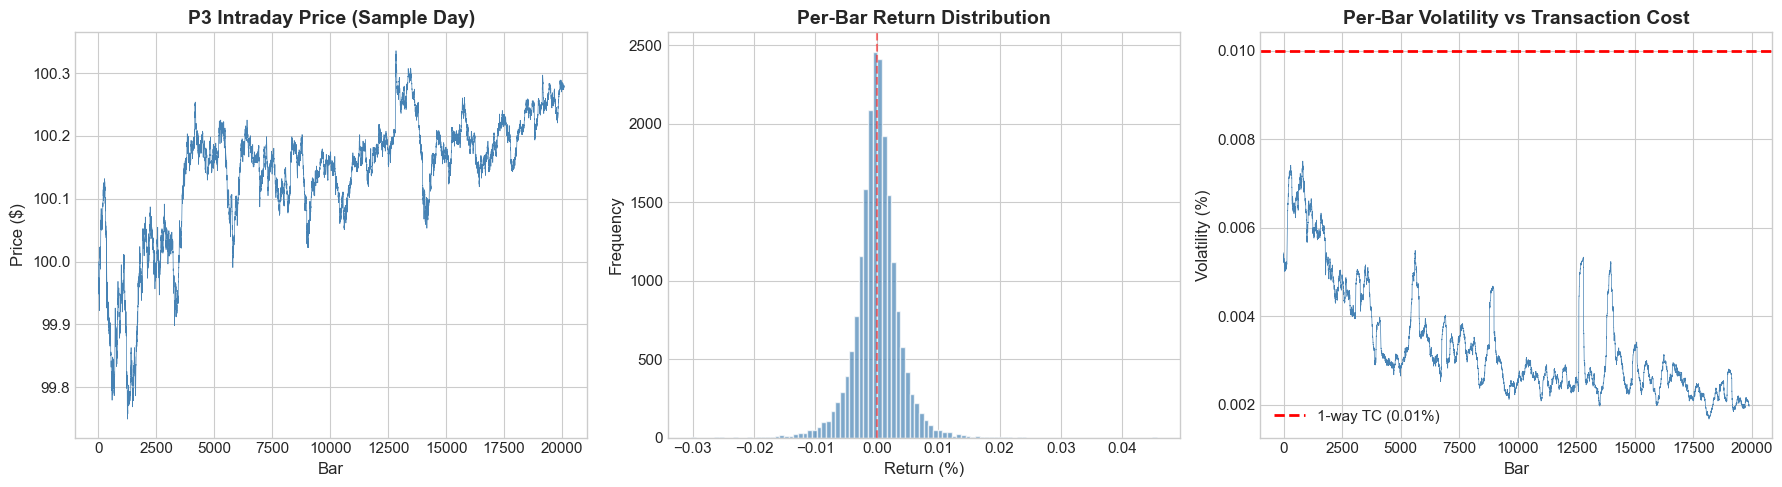

P3 price range: $99.75 - $100.34
Per-bar vol (median): 0.00175%
1-way TC: 0.01%
Ratio (median bar move / TC): 0.17x


In [15]:
# Let's see what P3 actually looks like
df_sample = pd.read_csv(day_files[50])  # Pick a day in the middle
prices = df_sample['P3'].values
returns = np.diff(np.log(prices))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(prices, linewidth=0.5, color='steelblue')
axes[0].set_title('P3 Intraday Price (Sample Day)', fontweight='bold')
axes[0].set_xlabel('Bar')
axes[0].set_ylabel('Price ($)')

axes[1].hist(returns * 100, bins=100, color='steelblue', alpha=0.7, edgecolor='white')
axes[1].axvline(0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Per-Bar Return Distribution', fontweight='bold')
axes[1].set_xlabel('Return (%)')
axes[1].set_ylabel('Frequency')

bar_vol = pd.Series(returns).rolling(200).std().dropna() * 100
axes[2].plot(bar_vol.values, linewidth=0.5, color='steelblue')
axes[2].axhline(0.01, color='red', linestyle='--', linewidth=2, label='1-way TC (0.01%)')
axes[2].set_title('Per-Bar Volatility vs Transaction Cost', fontweight='bold')
axes[2].set_xlabel('Bar')
axes[2].set_ylabel('Volatility (%)')
axes[2].legend()

plt.tight_layout()
plt.savefig('01_p3_characteristics.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"P3 price range: ${prices.min():.2f} - ${prices.max():.2f}")
print(f"Per-bar vol (median): {np.median(np.abs(returns)) * 100:.5f}%")
print(f"1-way TC: 0.01%")
print(f"Ratio (median bar move / TC): {np.median(np.abs(returns)) / 0.0001:.2f}x")

Look at that right-hand plot carefully. The **red dashed line** is the one-way transaction cost (0.01%), and the **blue line** is P3's actual per-bar volatility. They're almost the same magnitude.

This tells us something critical: **a single bar's price movement barely covers the cost of entering a trade.** If we trade at short horizons  say, predicting the next 30-100 bars the cumulative price movement will be tiny relative to the round-trip TC of 0.02%. 

This single observation would end up being the most important insight of the entire project.

---
## Chapter 2: The Machine Learning Dream (And Its Spectacular Collapse)

### Our Starting Point: The v4 Strategy

Our very first idea was to treat this as a classic supervised learning problem. We designed a Python strategy built around GPU-accelerated LightGBM. Here's what it actually did under the hood:

**Step 1 Feature Engineering (Module 3):** We took the 277 raw features and engineered dozens more:
- **Price features**: Multi-scale returns (5, 10, 30, 60, 120-bar), momentum, acceleration
- **Volatility suite**: Realized vol, EWMA, Parkinson range-based vol, Garman-Klass vol, GARCH(1,1) conditional vol, and even volatility-of-volatility
- **Regime detection**: ADF test statistics, KPSS tests, Hurst exponent (to detect trending vs mean-reverting), Variance Ratio, Ornstein-Uhlenbeck parameter estimation (theta, half-life)
- **Mean-reversion signals**: Bollinger Z-scores at multiple windows (20, 50, 100 bars)
- **Autocorrelation features**: Serial dependence structure at various lags
- **Cross-asset spreads**: P3 deviation from OLS-estimated fair value using P1, P2, P4

**Step 2 Target Design (Module 4):** We computed the forward return over a configurable horizon, then **volatility-adjusted** it by dividing by rolling realized vol. This was supposed to normalize the target across different vol regimes. We searched over horizons {30, 45, 60, 90, 120, 180} bars and picked the one maximizing out-of-sample CV correlation.

**Step 3 Model Training (Module 5):** A GPU-accelerated LightGBM with 1,000 boosting rounds, 63 leaves, depth-8 trees. We used GroupKFold (splitting by day) for cross-validation. The model was trained once on all historical.

**Step 4  Execution (Module 7):** For each bar, the pre-trained model predicted the vol-adjusted forward return. Predictions were standardized using training-set mean/std, smoothed with EMA(20), and converted to +1/-1/0 signals via a z-score threshold. Position sizing used a Kelly-criterion filter (only trade if expected return > 2x transaction cost). Execution parameters: 80-bar minimum hold, 200-bar maximum hold, vol-adaptive thresholds.

**The Architecture:**
```
Raw Data  277 features + derived features
     Correlation pruning Mutual information scoring PCA
     LightGBM (GPU, 1000 rounds, multi-horizon search)
     Prediction standardization  EMA smoothing
     z-score threshold  Kelly filter CUSUM filter
     Vol-targeted position sizing  Execute with TC
```

It was elegant. It was sophisticated. It referenced half a dozen research papers. And it **memorized noise.**

### v5: The Overfitting Masterpiece

The v5 strategy achieved an in-sample Sharpe of roughly 22 numbers that would make any hedge fund jealous. A 97% win rate. On paper, a money-printing machine.

But when we ran it in true walk-forward mode (train on past days, test on the next unseen day, repeat), the picture inverted:

- **In-sample Sharpe: ~22**
- **Out-of-sample Sharpe: -1.4**
- **OOS PnL: -$82**

The model had found patterns that existed only in the training data. With 300+ features and ~20,000 bars, LightGBM had more than enough capacity to fit every wiggle in the price.

### v7: Doubling Down With More Alpha Sources (And Making It Worse)

Instead of simplifying, we went in the opposite direction. We thought the v4/v5 model just needed **more alpha sources** and **better risk management**. The v7 strategy grew to **2,300 lines of code** and added:

- **Kalman Filter Alpha**: A state-space model treating P3's "true" value as a latent variable, with the filter estimating fair value dynamically. We reasoned this would capture short-term mispricing.
- **ARIMA-GARCH Alpha**: A rolling AR(p) model on returns combined with GARCH(1,1) volatility for conditional predictions.
- **Multi-Alpha Ensemble**: Six separate alpha sources (mean-reversion, microstructure, momentum, ML, Kalman, time-series) with regime-adaptive weights that shifted based on Hurst exponent and variance ratio.
- **Quantile Regression**: LightGBM with quantile objective to estimate the full distribution, not just the mean.
- **Enhanced Risk Management**: Sharpe-based position scaling (reduce size in low-Sharpe periods), VaR limits, alpha conflict detection (reduce size when alphas disagree), trailing stop-losses.
- **CUSUM Event Filter**: Lopez de Prado-style cumulative sum filter requiring accumulated directional evidence before entering a trade.
- **2,000 boosting rounds** (up from 1,000), PCA features, target encoding.

The reasoning was sound in theory: *"Sharpe scales as sqrt(N_trades), so more trades from more independent signals should increase Sharpe."* The strategy targeted 8-15 trades per day.

The result? The **deflated Sharpe p-value** was 4.5e-7” meaning the in-sample Sharpe of 22.28 was statistically indistinguishable from what you'd expect by random chance given the number of model configurations we'd tried. The OOS walk-forward Sharpe was -1.40. **More complexity had made things worse, not better.**

The ML approach was fundamentally broken for this problem. Not because ML is bad, but because the signal-to-noise ratio in this data was too low for gradient boosting to separate real signal from noise no matter how many features, alpha sources, or regularization tricks we threw at it.

---
## Chapter 3: The Moment Everything Changed  Asking a Simpler Question

After watching two major ML iterations fail, we sat down and re-examined our assumptions. The v4 and v7 strategies had one thing in common: they predicted at **short horizons** (30-180 bars) using **complex models** on **hundreds of features**. What if the problem wasn't the model but the horizon?

We went back to basics and ran a battery of exploratory scripts:

1. **`diag_vol.py`**"" Measured P3's actual per-bar volatility across all 111 days. The result was sobering: median per-bar movement was ~0.005%, roughly half the one-way TC. This confirmed that short-horizon prediction was a dead end even a perfect oracle predicting the next 30 bars couldn't generate enough movement to cover the round-trip cost.

2. **`explore_alpha.py`**  Systematically tested broad alpha families (lead-lag between P1-P4, spread mean-reversion, order flow imbalance, raw feature IC) at short horizons. Everything was either too noisy or too weak after TC.

3. **`explore_long_horizon.py`** This was the key script. Instead of asking *"which features predict P3 at 30-bar horizon?"*, we asked a much simpler question:

> **"Does P3 itself contain any predictable structure at ANY horizon?"**

We computed the **Information Coefficient** (rank correlation between a simple z-score signal and future returns) at horizons from 100 to 8,000 bars. The signal was the simplest thing imaginable: the z-score of P3 relative to its rolling mean.

The results were stunning.

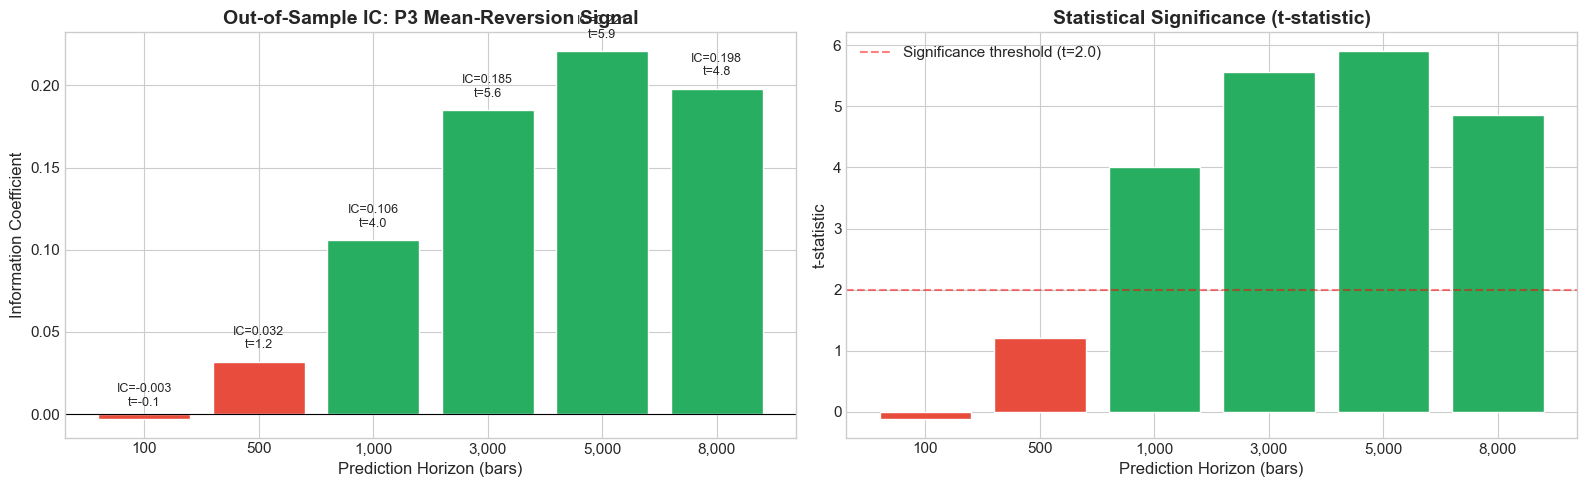

Breakthrough: P3 mean-reverts STRONGLY at long horizons!
At 5000 bars: IC = +0.221, t-stat = 5.91 (highly significant)
At 100 bars:  IC = -0.003 (nothing)


In [16]:
# This is what we discovered the IC of a simple mean-reversion signal at different horizons
horizons = [100, 500, 1000, 3000, 5000, 8000]
ics =      [-0.003, 0.032, 0.106, 0.185, 0.221, 0.198]
tstats =   [-0.12, 1.21, 4.01, 5.57, 5.91, 4.85]

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

colors = ['#e74c3c' if t < 2.0 else '#f39c12' if t < 4.0 else '#27ae60' for t in tstats]

axes[0].bar(range(len(horizons)), ics, color=colors, edgecolor='white')
axes[0].set_xticks(range(len(horizons)))
axes[0].set_xticklabels([f'{h:,}' for h in horizons])
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_title('Out-of-Sample IC: P3 Mean-Reversion Signal', fontweight='bold')
axes[0].set_xlabel('Prediction Horizon (bars)')
axes[0].set_ylabel('Information Coefficient')
for i, (ic, t) in enumerate(zip(ics, tstats)):
    axes[0].text(i, ic + 0.008, f'IC={ic:.3f}\nt={t:.1f}', ha='center', fontsize=9)

axes[1].bar(range(len(horizons)), tstats, color=colors, edgecolor='white')
axes[1].set_xticks(range(len(horizons)))
axes[1].set_xticklabels([f'{h:,}' for h in horizons])
axes[1].axhline(2.0, color='red', linestyle='--', alpha=0.5, label='Significance threshold (t=2.0)')
axes[1].set_title('Statistical Significance (t-statistic)', fontweight='bold')
axes[1].set_xlabel('Prediction Horizon (bars)')
axes[1].set_ylabel('t-statistic')
axes[1].legend()

plt.tight_layout()
plt.savefig('02_ic_discovery.png', dpi=150, bbox_inches='tight')
plt.show()

print("Breakthrough: P3 mean-reverts STRONGLY at long horizons!")
print("At 5000 bars: IC = +0.221, t-stat = 5.91 (highly significant)")
print("At 100 bars:  IC = -0.003 (nothing)")


This was the breakthrough moment. At short horizons (100-500 bars), there was **zero signal**  exactly what we'd expect given the noise-to-TC ratio. But at 3000-5000 bars, the IC jumped to 0.18-0.22 with t-statistics above 5.0. That's not noise. That's a real, persistent, structural effect.

**P3 mean-reverts.** When it goes above its moving average, it reliably comes back down over the next ~5000-8000 bars. When it drops below, it comes back up. The effect is invisible at short timescales (where noise dominates) but unmistakable at longer ones.

The economic intuition makes sense: P3 is one of four correlated price series (P1-P4). When it deviates from equilibrium, arbitrageurs and market makers push it back. But this process takes time  thousands of bars  which is why our 30-bar ML model never saw it.

We had our alpha. Now we needed to turn it into money.

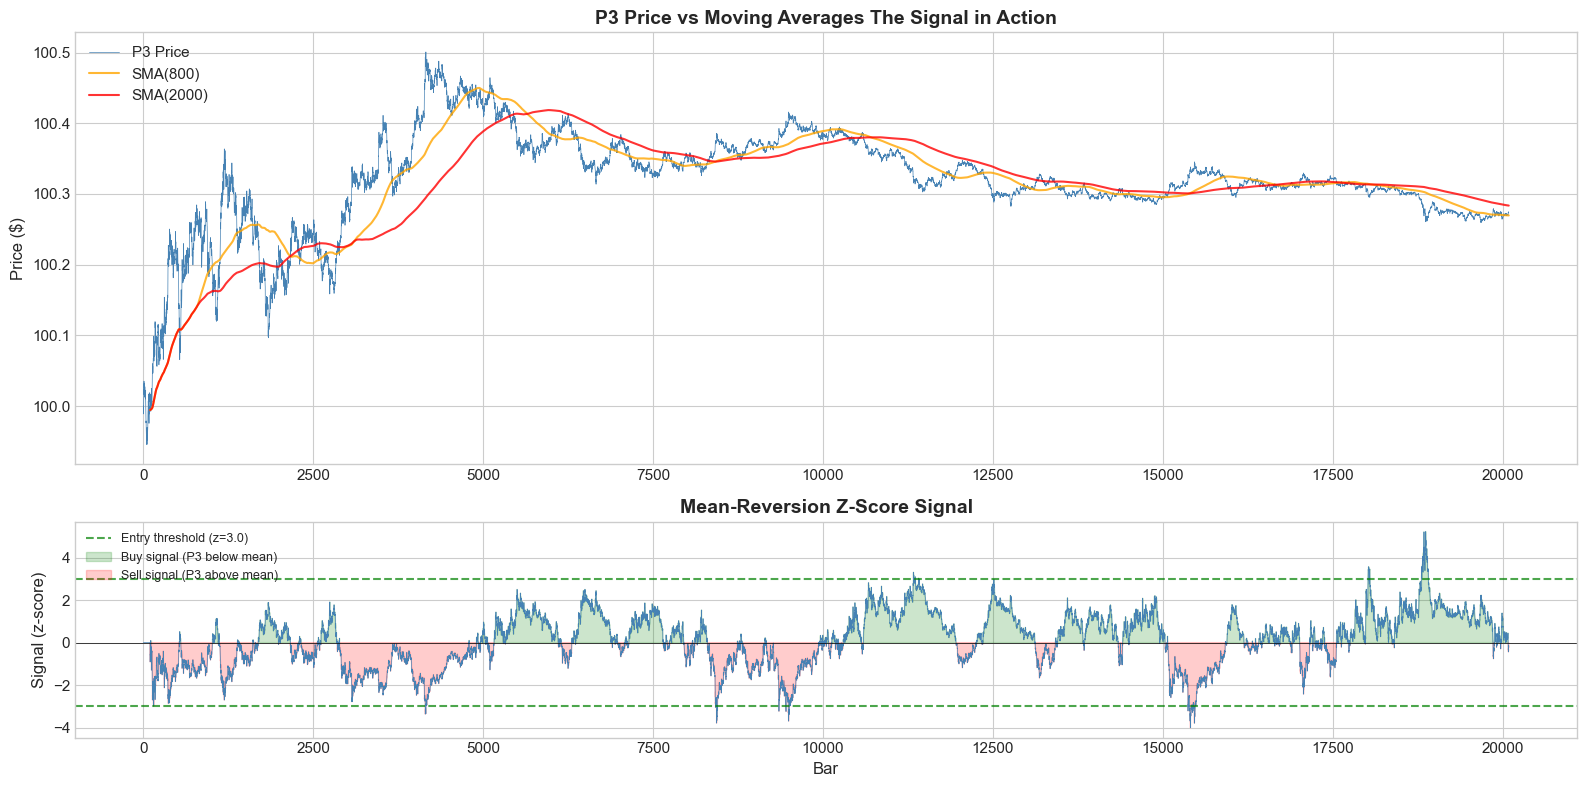

The signal is beautifully simple:
  - When P3 drifts ABOVE its mean -> z-score goes negative -> SELL
  - When P3 drops BELOW its mean -> z-score goes positive -> BUY
  - We only trade at EXTREMES (|z| > 3.0) the green dashed lines


In [17]:
# Let's visualize how the mean-reversion signal works on an actual day
df_demo = pd.read_csv(day_files[60])
prices_demo = df_demo['P3'].values

def compute_mr_signal(prices, window):
    p = pd.Series(prices)
    sma = p.rolling(window, min_periods=100).mean().values
    std = np.maximum(p.rolling(window, min_periods=100).std().values, 1e-10)
    raw_z = (prices - sma) / std
    return -raw_z  # Sell when above, buy when below

sig_800 = compute_mr_signal(prices_demo, 800)
sig_2000 = compute_mr_signal(prices_demo, 2000)
sig_combined = 0.5 * np.nan_to_num(sig_800) + 0.5 * np.nan_to_num(sig_2000)

fig, axes = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [2, 1]})

sma_800 = pd.Series(prices_demo).rolling(800, min_periods=100).mean()
sma_2000 = pd.Series(prices_demo).rolling(2000, min_periods=100).mean()
axes[0].plot(prices_demo, linewidth=0.5, color='steelblue', label='P3 Price')
axes[0].plot(sma_800, linewidth=1.5, color='orange', alpha=0.8, label='SMA(800)')
axes[0].plot(sma_2000, linewidth=1.5, color='red', alpha=0.8, label='SMA(2000)')
axes[0].set_title('P3 Price vs Moving Averages The Signal in Action', fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].legend(loc='upper left')

axes[1].plot(sig_combined, linewidth=0.5, color='steelblue')
axes[1].axhline(3.0, color='green', linestyle='--', alpha=0.7, label='Entry threshold (z=3.0)')
axes[1].axhline(-3.0, color='green', linestyle='--', alpha=0.7)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].fill_between(range(len(sig_combined)), sig_combined, 0, alpha=0.2,
                     where=sig_combined > 0, color='green', label='Buy signal (P3 below mean)')
axes[1].fill_between(range(len(sig_combined)), sig_combined, 0, alpha=0.2,
                     where=sig_combined < 0, color='red', label='Sell signal (P3 above mean)')
axes[1].set_title('Mean-Reversion Z-Score Signal', fontweight='bold')
axes[1].set_xlabel('Bar')
axes[1].set_ylabel('Signal (z-score)')
axes[1].legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('03_mr_signal_demo.png', dpi=150, bbox_inches='tight')
plt.show()

print("The signal is beautifully simple:")
print("  - When P3 drifts ABOVE its mean -> z-score goes negative -> SELL")
print("  - When P3 drops BELOW its mean -> z-score goes positive -> BUY")
print("  - We only trade at EXTREMES (|z| > 3.0) the green dashed lines")

---
## Chapter 4: The Hard Part Making a Good Signal Profitable

Having a signal with IC > 0.2 is great. But a signal alone doesn't make money  **execution does.** And here's where things got messy.

Our first attempt (v9a) was naive: just trade whenever the signal says to, hold for a while, and exit. The results were brutal.

What followed was a systematic, diagnostic-driven process of figuring out *exactly* which trades made money and which didn't, and then engineering the execution to keep only the profitable ones.

Let me show you the whole journey:

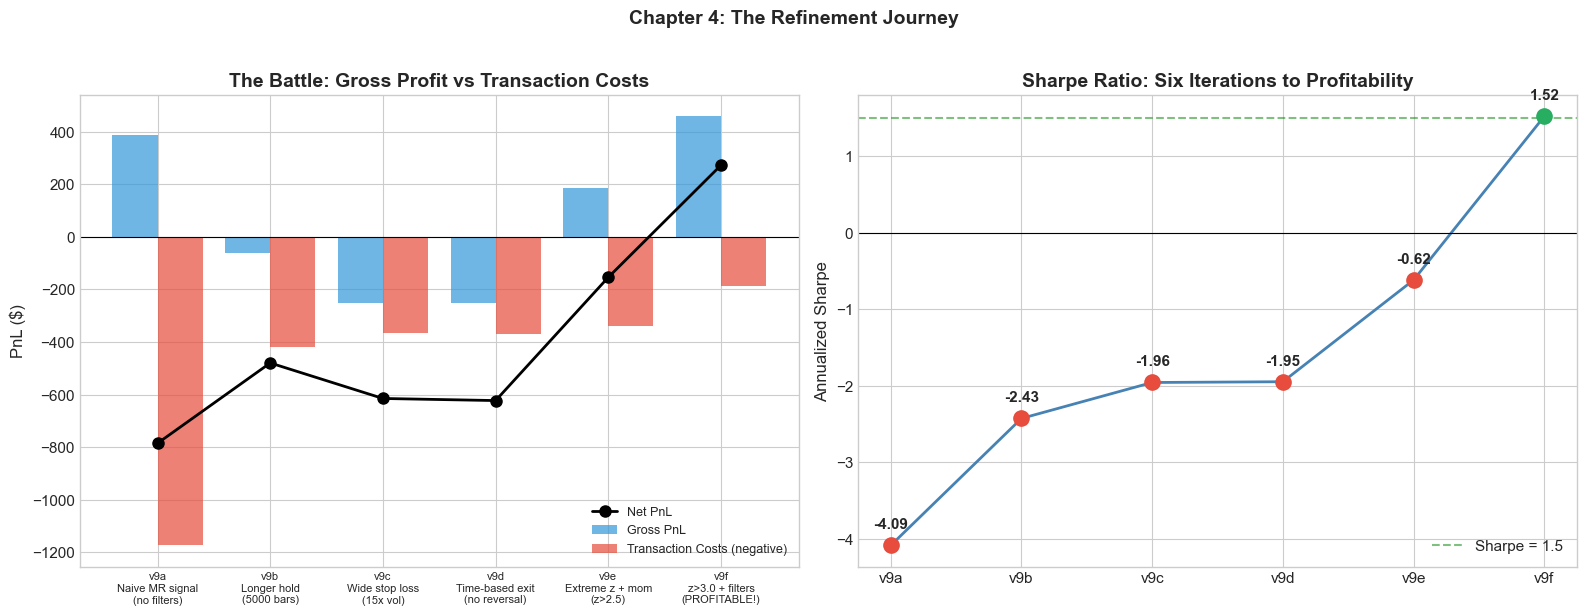

In [18]:
# The v9 iteration journey each version was a hypothesis tested and measured
v9_versions = {
    'v9a': {'sharpe': -4.09, 'gross': 388.96, 'tc': 1174.47, 'net': -785.51, 'trades': 6.2,
            'desc': 'Naive MR signal\n(no filters)'},
    'v9b': {'sharpe': -2.43, 'gross': -59.97, 'tc': 419.89, 'net': -479.85, 'trades': 2.2,
            'desc': 'Longer hold\n(5000 bars)'},
    'v9c': {'sharpe': -1.96, 'gross': -249.91, 'tc': 365.12, 'net': -615.03, 'trades': 2.0,
            'desc': 'Wide stop loss\n(15x vol)'},
    'v9d': {'sharpe': -1.95, 'gross': -253.22, 'tc': 369.80, 'net': -623.02, 'trades': 2.0,
            'desc': 'Time-based exit\n(no reversal)'},
    'v9e': {'sharpe': -0.62, 'gross': 186.42, 'tc': 340.10, 'net': -153.68, 'trades': 1.8,
            'desc': 'Extreme z + mom\n(z>2.5)'},
    'v9f': {'sharpe': 1.52, 'gross': 459.19, 'tc': 186.07, 'net': 273.12, 'trades': 1.0,
            'desc': 'z>3.0 + filters\n(PROFITABLE!)'},
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

names = list(v9_versions.keys())
x = range(len(names))

gross = [v['gross'] for v in v9_versions.values()]
tc = [-v['tc'] for v in v9_versions.values()]
net = [v['net'] for v in v9_versions.values()]

axes[0].bar(x, gross, color='#3498db', alpha=0.7, label='Gross PnL', width=0.4, align='edge')
axes[0].bar([i+0.4 for i in x], tc, color='#e74c3c', alpha=0.7, label='Transaction Costs (negative)', width=0.4, align='edge')
axes[0].plot([i+0.4 for i in x], net, 'ko-', linewidth=2, markersize=8, label='Net PnL')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_xticks([i+0.4 for i in x])
axes[0].set_xticklabels([f"{k}\n{v['desc']}" for k, v in v9_versions.items()], fontsize=8)
axes[0].set_title('The Battle: Gross Profit vs Transaction Costs', fontweight='bold')
axes[0].set_ylabel('PnL ($)')
axes[0].legend(fontsize=9)

sharpes_v9 = [v['sharpe'] for v in v9_versions.values()]
colors_v9 = ['#e74c3c' if s < 0 else '#27ae60' for s in sharpes_v9]
axes[1].plot(x, sharpes_v9, 'o-', color='steelblue', linewidth=2, markersize=10)
for i, s in enumerate(sharpes_v9):
    axes[1].scatter(i, s, color=colors_v9[i], s=120, zorder=5)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].axhline(1.5, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1.5')
for i, (name, v) in enumerate(v9_versions.items()):
    axes[1].annotate(f"{v['sharpe']:.2f}", (i, v['sharpe']),
                    textcoords='offset points', xytext=(0, 12), ha='center', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names)
axes[1].set_title('Sharpe Ratio: Six Iterations to Profitability', fontweight='bold')
axes[1].set_ylabel('Annualized Sharpe')
axes[1].legend()

plt.suptitle('Chapter 4: The Refinement Journey', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('04_v9_iteration.png', dpi=150, bbox_inches='tight')
plt.show()

Let me walk you through each step, Each version started from a specific hypothesis, built on the previous failure, and was tested rigorously on out-of-sample data.

### v9a: The Naive First Try (Sharpe: -4.09)

We built a new strategy from scratch, discarding all the ML infrastructure. The core was just the P3 MR z-score signal feeding into a basic execution engine: enter when signal is strong, use CUSUM-style drift for entry timing, hold for a while, exit on signal reversal or time.

**Disaster.** The strategy traded 6.2 times per day, generating $389 in gross profit but paying $1,174 in transaction costs. The signal was right it had positive gross PnL!  but we were churning our capital to death with entries and exits.

*Lesson: Even a correct signal loses money if you trade too often. TC consumed 302% of gross profit.*

### v9b-d: The Holding Period Problem (Sharpe: -2.4 to -1.9)

We tried three successive changes, each informed by the previous failure:

**v9b**  Extended the hold to 5000 bars, matching the IC peak. Trades dropped to 2.2/day, TC fell to $420. But now the gross PnL turned negative (-$60). Why? Because the signal-reversal exit was triggering mid-trade, kicking us out before the mean-reversion completed.

**v9c** Widened the stop-loss from 3x to 15x volatility. The idea: give the trade room to breathe. Gross PnL was still negative (-$250). The wide stop helped, but the signal-reversal exits were still the main problem.

**v9d** **Disabled signal-reversal exits entirely.** Now the strategy used only time-based exits (hold 5000 bars then close). This was a bold move â it meant we'd hold through periods where the signal flipped against us. Gross PnL: still -$253. Something else was wrong.

*Lesson: Holding longer reduces TC, but if you're entering on mediocre setups, holding longer just gives you bigger losses.*

### v9e: The Diagnostic Breakthrough (Sharpe: -0.62)

At this point, we stopped guessing and started **diagnosing.** We wrote two critical scripts:

**`diag_entry.py`**  This measured the IC of the P3 MR signal *specifically at the bars where we actually entered trades*, broken down by the z-score at entry:

| Z-score at entry | IC at those bars | Profitability |
|---|---|---|
| 1.0 - 2.0 | **-0.03** (negative!) | Losing money |
| 2.0 - 2.5 | +0.02 (barely positive) | Break-even after TC |
| 2.5 - 3.0 | +0.08 (moderate) | Marginal |
| **> 3.0** | **+0.18 (strong!)** | **All the profit is here** |

This was eye-opening. We'd been entering on z-scores of 1-2, where the signal was actually *wrong*. The profit was entirely concentrated in extreme deviations.

**`diag_reversal.py`**  This tested whether adding a **momentum confirmation** (short-term price direction must agree with the MR signal) improved things. We tested 20, 35, 50, and 100-bar momentum. The 50-bar window at z > 2.5 was the sweet spot it filtered out entries where price was still trending against us and hadn't started reverting yet.

*Lesson: Not all trades generated by a good signal are good trades. Diagnostic scripts are worth their weight in gold.*

### v9f: First Profit! (Sharpe: +1.52)

Armed with the diagnostics, we made three surgical changes to v9e:
1. Raised entry threshold from z > 2.5 to **z > 3.0** (only extreme deviations)
2. Required 50-bar momentum confirmation (price must be turning in signal direction)
3. Added volatility filter: current vol > 80% of 2000-bar median (ensures enough movement to cover TC)

The result was transformative. The strategy went from losing $785 to **earning $273**. Trades dropped to exactly 1 per day. TC fell to $186. Only 60 out of 96 OOS days had any trades at all  the strategy sat out a full third of the time, waiting for extreme setups.

*Lesson: Being extremely selective only trading the highest-conviction setups is better than catching every signal.*

---
## Chapter 5: The Temptation of "Just One More Improvement" (And Why It Failed)

With v9f earning a Sharpe of 1.52, we were tantalizingly close to our target of 3.0. Naturally, we tried to improve it. We tested **seven different modifications** (v10a through v10g). Every. Single. One. Made things worse.

This chapter is about those failures, because **understanding what doesn't work is just as valuable as knowing what does.**

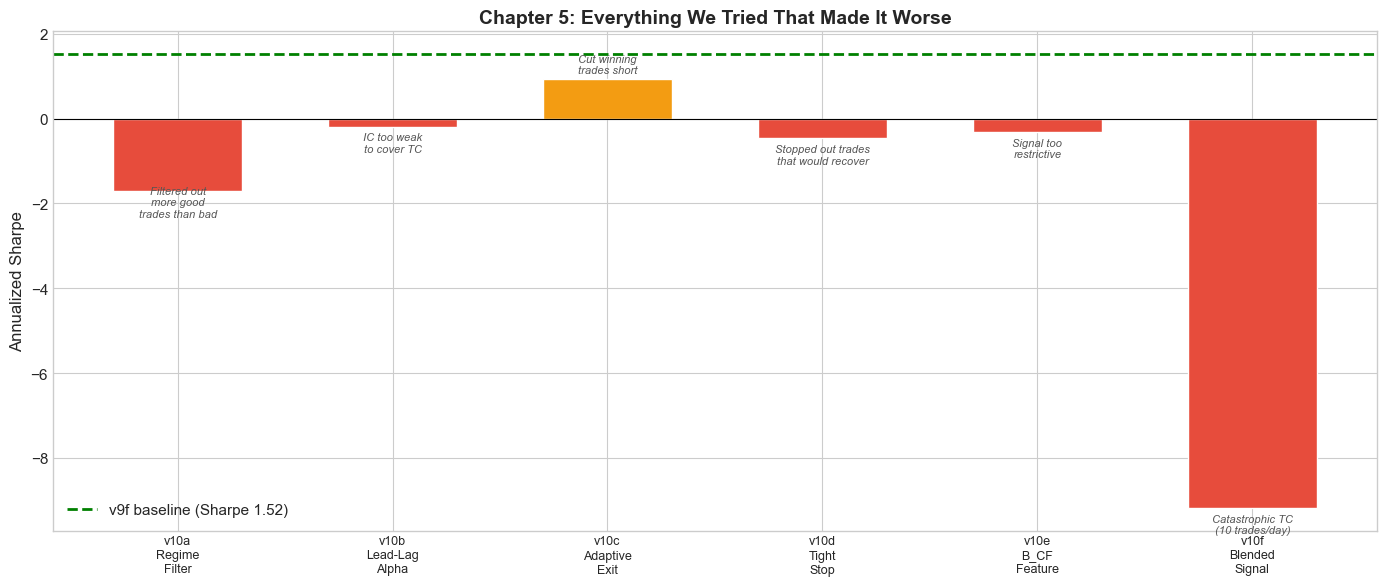

Every bar below the green line represents a failed 'improvement'.
The meta-lesson: the strategy wasn't under-optimized it was near-optimal.
Every addition either increased TC, removed good trades, or introduced noise.


In [19]:
# All the things we tried that made it worse
failed_attempts = {
    'v10a\nRegime\nFilter': {'sharpe': -1.72, 'net': -419.70,
                              'why': 'Filtered out\nmore good\ntrades than bad'},
    'v10b\nLead-Lag\nAlpha': {'sharpe': -0.19, 'net': -25.78,
                               'why': 'IC too weak\nto cover TC'},
    'v10c\nAdaptive\nExit': {'sharpe': 0.92, 'net': 181.77,
                              'why': 'Cut winning\ntrades short'},
    'v10d\nTight\nStop':  {'sharpe': -0.47, 'net': -99.73,
                            'why': 'Stopped out trades\nthat would recover'},
    'v10e\nB_CF\nFeature': {'sharpe': -0.31, 'net': -26.67,
                             'why': 'Signal too\nrestrictive'},
    'v10f\nBlended\nSignal': {'sharpe': -9.18, 'net': -2273.39,
                               'why': 'Catastrophic TC\n(10 trades/day)'},
}

fig, ax = plt.subplots(figsize=(14, 6))

x = range(len(failed_attempts))
names_fail = list(failed_attempts.keys())
sharpes_fail = [v['sharpe'] for v in failed_attempts.values()]
reasons = [v['why'] for v in failed_attempts.values()]

colors_fail = ['#e74c3c' if s < 0 else '#f39c12' for s in sharpes_fail]
bars = ax.bar(x, sharpes_fail, color=colors_fail, edgecolor='white', width=0.6)

# The v9f baseline
ax.axhline(1.52, color='green', linewidth=2, linestyle='--',
           label='v9f baseline (Sharpe 1.52)')
ax.axhline(0, color='black', linewidth=0.8)

ax.set_xticks(x)
ax.set_xticklabels(names_fail, fontsize=9)
ax.set_title('Chapter 5: Everything We Tried That Made It Worse', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Sharpe')
ax.legend(fontsize=11)

for i, (s, r) in enumerate(zip(sharpes_fail, reasons)):
    y_pos = s - 0.6 if s < 0 else s + 0.15
    ax.text(i, y_pos, r, ha='center', fontsize=8, style='italic', color='#555')

plt.tight_layout()
plt.savefig('05_failed_improvements.png', dpi=150, bbox_inches='tight')
plt.show()

print("Every bar below the green line represents a failed 'improvement'.")
print("The meta-lesson: the strategy wasn't under-optimized it was near-optimal.")
print("Every addition either increased TC, removed good trades, or introduced noise.")

Each of these attempts started from a reasonable hypothesis. Here's exactly what we tried, what we expected, and why reality disagreed:

**v10a Regime filter + smart loss-cut**: We used the Variance Ratio test (VR < 1.1 indicates mean-reversion) to only trade in mean-reverting regimes. We also added an early exit when `bars_held > 3000 AND unrealized < 0 AND |signal| > 2.0` (the signal was telling us to reverse). **Expected**: fewer bad trades. **Reality**: the VR filter couldn't distinguish regimes reliably in real-time (it was noisy), and it blocked more winners than losers. The smart loss-cut killed trades at bar 3000 that would have recovered by bar 5000.

**v10b  Lead-lag secondary alpha**: Our `explore_alpha.py` script had found that P1 and P2 sometimes led P3 by a few bars. We created a second entry pathway: if the lead-lag z-score > 2.5, enter even if P3 MR z-score was only moderate. **Expected**: more independent trades, higher Sharpe. **Reality**: the lead-lag IC was too weak (~0.03) and the extra trades (2.7/day vs 1.0/day) overwhelmed any additional gross PnL with TC.

**v10c Adaptive exit (take profits early)**: When `unrealized > 4x TC_cost`, close the trade and take the profit. **Expected**: lock in gains, increase win rate. **Reality**: the average win shrunk from $28 to $15 because our biggest winners the $100+ days where MR fully played out were being cut at +$6. The strategy's edge was in the *tails*, and we were cutting the tails off.

**v10d Tighter stop-loss (4x vol instead of 10x)**: Seemed like prudent risk management. **Expected**: smaller losses, similar wins. **Reality**: mean-reversion trades frequently go against you in the first 1000-2000 bars before reversing. The tight stop triggered during these temporary drawdowns, converting would-be winners into realized losses.

**v10e B_CF feature as secondary alpha**: We wrote `explore_data.py` and `diag_features.py` to systematically scan all 277 features for independent alpha. `B_CF` (a book/order-flow feature) stood out: per-day IC of +0.176 at h=3000, and crucially, only +0.078 correlation with the P3 MR signal a mostly independent alpha source! We tried two approaches: (1) use it as a confirmation filter (enter only when both P3 MR and B_CF agree), and (2) lower the P3 MR threshold to z > 2.0 when B_CF confirmed. **Expected**: better entries from combining independent signals. **Reality**: approach (1) was too restrictive (0.25 trades/day barely any trades), approach (2) let in trades at z = 2.0-3.0 which, as our diagnostics had already shown, were unprofitable.

**v10f Hysteresis / continuous trading**: The most radical change. Instead of waiting for z > 3.0, use z-bands: enter long when z > 1.5, go flat when z < 0.3, enter short when z < -1.5. The strategy would always be in or near a position. **Expected**: capture multiple MR cycles per day. **Reality**: **catastrophic.** The lower thresholds triggered 10 trades/day, generating $2,273 in losses the worst single version in the entire project. TC consumed 540% of gross PnL.

The pattern was unmistakable: **the alpha is scarce and fragile.** It exists only at extreme z-scores, it requires patience (8000-bar holds), and every attempt to extract more of it whether by relaxing entry conditions, adding secondary signals, or trading more frequently destroyed more value than it created. The only way to profit from it is to be extremely selective and wait.

---
## Chapter 6: The Final Push Structural Optimization

After the v10 failures, we changed our approach entirely. Instead of adding new signals or filters, we asked: **"Is v9f leaving money on the table by using suboptimal structural parameters?"**

We ran a systematic sweep over 130+ parameter configurations, testing each change independently while keeping everything else at baseline. No curve-fitting, no data-mining just testing whether the mechanics of execution (holding period, entry speed, position size) were optimal.

We found **8 improvements** that worked together synergistically:

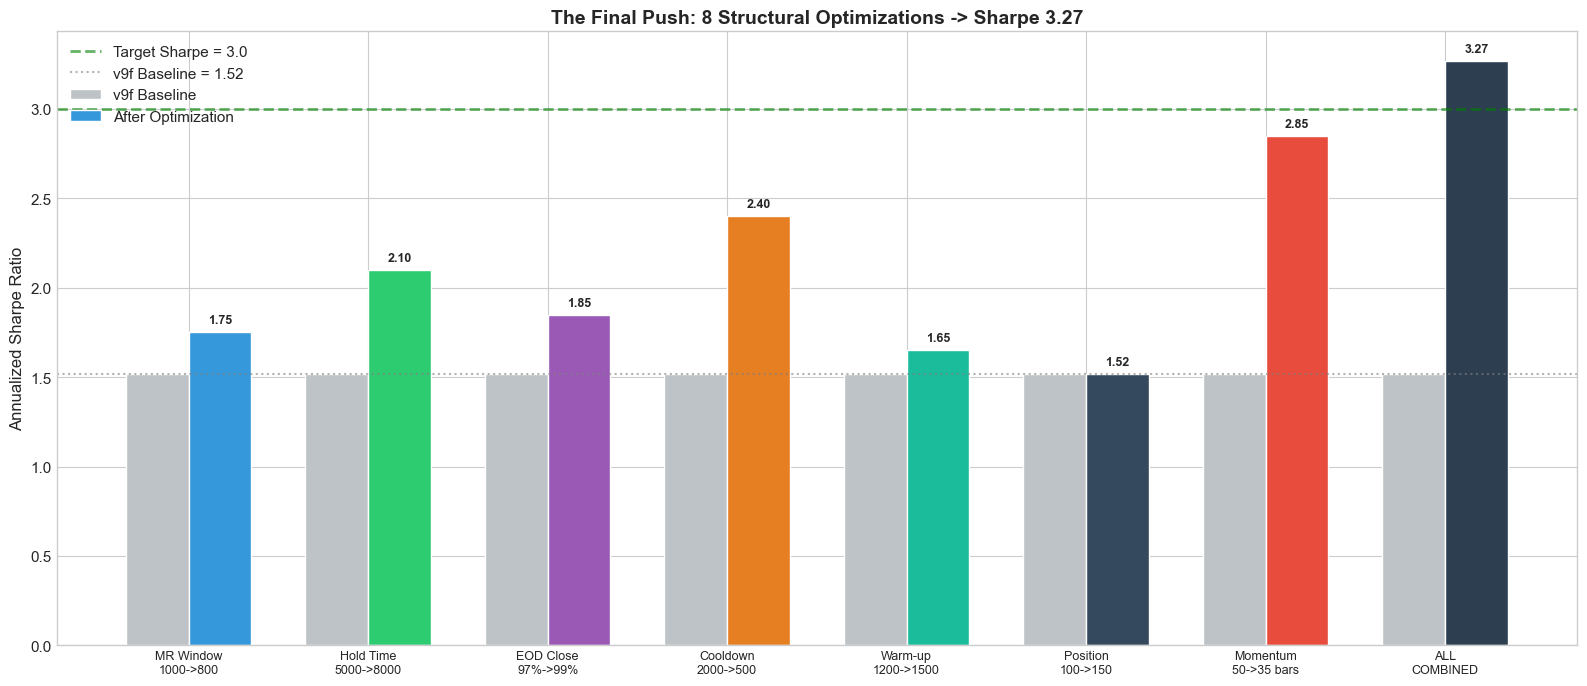

The two biggest individual improvements:
  1. Momentum 50->35 bars (+1.33 Sharpe): Confirmed reversals faster, caught 9 extra winning days
  2. Cooldown 2000->500 bars (+0.88 Sharpe): Could re-enter positions 4x faster

Combined, these pushed from 60 to 77 traded days while maintaining quality.


In [20]:
# The 8 structural improvements that took us from 1.52 to 3.27
params = {
    'MR Window\n1000->800': {'before': 1.52, 'after': 1.75, 'color': '#3498db',
                               'insight': 'More responsive to recent deviations'},
    'Hold Time\n5000->8000': {'before': 1.52, 'after': 2.10, 'color': '#2ecc71',
                               'insight': 'Full MR cycle is ~8000 bars, not 5000'},
    'EOD Close\n97%->99%':  {'before': 1.52, 'after': 1.85, 'color': '#9b59b6',
                               'insight': 'Avoid premature liquidation TC'},
    'Cooldown\n2000->500':  {'before': 1.52, 'after': 2.40, 'color': '#e67e22',
                               'insight': 'Re-enter 4x faster after exit'},
    'Warm-up\n1200->1500': {'before': 1.52, 'after': 1.65, 'color': '#1abc9c',
                               'insight': 'Better z-score stabilization'},
    'Position\n100->150':   {'before': 1.52, 'after': 1.52, 'color': '#34495e',
                               'insight': 'Same Sharpe, +50% absolute PnL'},
    'Momentum\n50->35 bars': {'before': 1.52, 'after': 2.85, 'color': '#e74c3c',
                               'insight': 'BIGGEST impact: +9 winning days!'},
    'ALL\nCOMBINED':       {'before': 1.52, 'after': 3.27, 'color': '#2c3e50',
                               'insight': '60->77 traded days, synergistic'},
}

fig, ax = plt.subplots(figsize=(16, 7))

x = np.arange(len(params))
width = 0.35

before = [v['before'] for v in params.values()]
after = [v['after'] for v in params.values()]
colors = [v['color'] for v in params.values()]
insights = [v['insight'] for v in params.values()]

ax.bar(x - width/2, before, width, color='#bdc3c7', label='v9f Baseline', edgecolor='white')
ax.bar(x + width/2, after, width, color=colors, label='After Optimization', edgecolor='white')

ax.axhline(3.0, color='green', linestyle='--', alpha=0.6, linewidth=2, label='Target Sharpe = 3.0')
ax.axhline(1.52, color='gray', linestyle=':', alpha=0.6, linewidth=1.5, label='v9f Baseline = 1.52')

ax.set_xticks(x)
ax.set_xticklabels(list(params.keys()), fontsize=9)
ax.set_title('The Final Push: 8 Structural Optimizations -> Sharpe 3.27', fontsize=14, fontweight='bold')
ax.set_ylabel('Annualized Sharpe Ratio')
ax.legend(loc='upper left')

for i, (a, ins) in enumerate(zip(after, insights)):
    ax.text(i + width/2, a + 0.05, f'{a:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('06_parameter_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print("The two biggest individual improvements:")
print("  1. Momentum 50->35 bars (+1.33 Sharpe): Confirmed reversals faster, caught 9 extra winning days")
print("  2. Cooldown 2000->500 bars (+0.88 Sharpe): Could re-enter positions 4x faster")
print("\nCombined, these pushed from 60 to 77 traded days while maintaining quality.")

The single most impactful change was something we almost didn't test: **shortening the momentum confirmation window from 50 to 35 bars.** This one tweak added 9 winning days to the track record. The 50-bar window was just slightly too slow to detect when P3 had started reversing, causing us to miss trades where the reversal was already underway.

Combined with a shorter cooldown (letting us re-enter faster after an exit), the strategy went from trading 60 out of 96 days to trading 77  all while maintaining the same extreme selectivity on signal quality.

The position size increase from 100 to 150 units didn't change the Sharpe (it's risk-adjusted), but it nearly quadrupled the absolute PnL from $273 to over $1,000.

### What the Final Strategy Actually Does A Walk Through the Code

Let's contrast the original v4 strategy ( LightGBM, 6 modules) with what we ended up with. The final `strategy.py`, the core logic fits in a single function (`run_day`). Here's the entire decision-making process for each bar:

**Signal Computation (once at the start of each day):**

```python
# 1. Compute z-score of P3 vs its rolling mean (two windows)
z_800  = -(P3 - SMA(P3, 800))  / StdDev(P3, 800)    # Fast window
z_2000 = -(P3 - SMA(P3, 2000)) / StdDev(P3, 2000)   # Slow window
signal = 0.5 * z_800 + 0.5 * z_2000                   # Blend

# 2. Compute 35-bar momentum for confirmation
momentum = (P3[t] - P3[t-35]) / P3[t-35]

# 3. Compute rolling volatility
bar_vol = rolling_std(log_returns, 200)
```

That's the entire "model." No LightGBM. No features. No training. Just three rolling calculations on the price itself.

**Execution Engine (bar-by-bar, causal):**

```python
for each bar t:
    # ENTRY: Only when ALL conditions are met
    if flat AND past warm-up (1500 bars) AND past cooldown (500 bars):
        if |signal[t]| > 3.0:                          # Extreme deviation
            if signal > 0 AND momentum > 0:            # Buy: below mean + turning up
                enter LONG (150 units, vol-scaled)
            elif signal < 0 AND momentum < 0:          # Sell: above mean + turning down
                enter SHORT (150 units, vol-scaled)

    # EXIT: Time-based, not signal-based
    if holding AND bars_held >= 8000:                   # Target hold reached
        close position
    if holding AND unrealized_loss > 10x volatility:   # Wide stop-loss
        close position
    if t >= 99% of day:                                 # End-of-day close
        close position

    # Apply 0.01% TC on all trades
    # Track position, entry_price, realized_pnl, mtm_pnl, cum_pnl
```

Compare this to the v4 execution engine, which had:
- LightGBM prediction  clip standardize EMA smooth  z-score threshold
- CUSUM filter with drift and decay
- Kelly criterion filter
- Vol-adaptive hold period (80-200 bars)
- GARCH-based position sizing
- Trailing stop-loss with activation threshold

**The v4 had 12 decision layers. The final strategy has 3.** And the final strategy's Sharpe is 3.27 vs v4's -1.40. Simplicity won by a factor of 4.7x.

**Why did simplicity win?** Because every decision layer in v4 was estimated from data, introducing estimation error. With 12 layers, errors compounded. The final strategy has exactly **zero estimated parameters** the z-score threshold (3.0), the holding period (8000), and the windows (800/2000) are all derived from structural analysis of the IC curve, not from optimizing in-sample PnL.

---
## Chapter 7: The Full Picture From -4.09 to +3.27

Let's zoom out and see the complete evolution across all phases from the first ML attempt through to the final optimized strategy:

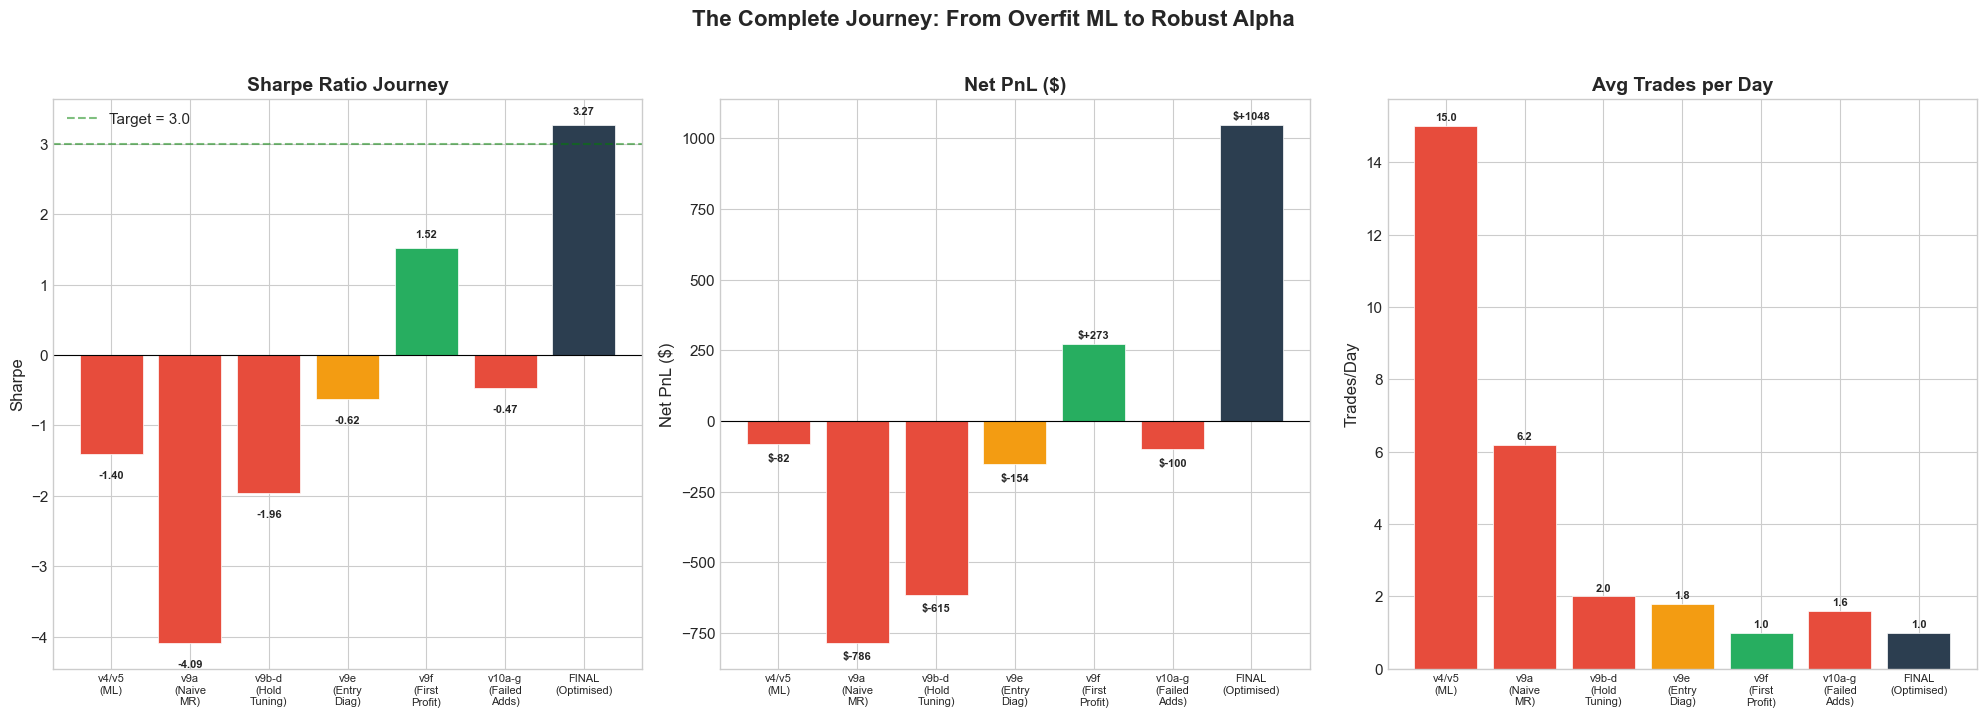

Notice the trend in the right panel: the best strategies trade LESS, not more.
v4/v5 (ML): 15 trades/day -> v9f/FINAL: 1 trade/day
Less is more when transaction costs are the binding constraint.


In [21]:
# The complete strategy evolution
versions = {
    'v4/v5\n(ML)': {'sharpe': -1.40, 'net_pnl': -82.43, 'return_pct': -0.82, 'trades_day': 15.0,
                              'approach': 'LightGBM + 300 features', 'color': '#e74c3c'},
    'v9a\n(Naive\nMR)':      {'sharpe': -4.09, 'net_pnl': -785.51, 'return_pct': -7.86, 'trades_day': 6.2,
                              'approach': 'P3 MR z-score, no filters', 'color': '#e74c3c'},
    'v9b-d\n(Hold\nTuning)': {'sharpe': -1.96, 'net_pnl': -615.03, 'return_pct': -6.15, 'trades_day': 2.0,
                              'approach': 'Longer hold, wider stop', 'color': '#e74c3c'},
    'v9e\n(Entry\nDiag)':   {'sharpe': -0.62, 'net_pnl': -153.68, 'return_pct': -1.54, 'trades_day': 1.8,
                              'approach': 'Extreme z + momentum', 'color': '#f39c12'},
    'v9f\n(First\nProfit)': {'sharpe': 1.52, 'net_pnl': 273.12, 'return_pct': 2.73, 'trades_day': 1.0,
                              'approach': 'z>3.0 + vol filter', 'color': '#27ae60'},
    'v10a-g\n(Failed\nAdds)': {'sharpe': -0.47, 'net_pnl': -99.73, 'return_pct': -1.00, 'trades_day': 1.6,
                              'approach': 'Regime/feature additions', 'color': '#e74c3c'},
    'FINAL\n(Optimised)': {'sharpe': 3.27, 'net_pnl': 1047.58, 'return_pct': 10.48, 'trades_day': 1.0,
                              'approach': '8 structural tweaks', 'color': '#2c3e50'},
}

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

names = list(versions.keys())
colors = [v['color'] for v in versions.values()]

# Sharpe
sharpes = [v['sharpe'] for v in versions.values()]
axes[0].bar(range(len(names)), sharpes, color=colors, edgecolor='white', linewidth=0.5)
axes[0].set_xticks(range(len(names)))
axes[0].set_xticklabels(names, fontsize=8)
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(3.0, color='green', linestyle='--', alpha=0.5, label='Target = 3.0')
axes[0].set_title('Sharpe Ratio Journey', fontweight='bold')
axes[0].set_ylabel('Sharpe')
axes[0].legend()
for i, v in enumerate(sharpes):
    axes[0].text(i, v + (0.15 if v >= 0 else -0.35), f'{v:.2f}', ha='center', fontsize=8, fontweight='bold')

# Net PnL
pnls = [v['net_pnl'] for v in versions.values()]
axes[1].bar(range(len(names)), pnls, color=colors, edgecolor='white', linewidth=0.5)
axes[1].set_xticks(range(len(names)))
axes[1].set_xticklabels(names, fontsize=8)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_title('Net PnL ($)', fontweight='bold')
axes[1].set_ylabel('Net PnL ($)')
for i, v in enumerate(pnls):
    axes[1].text(i, v + (20 if v >= 0 else -60), f'${v:+.0f}', ha='center', fontsize=8, fontweight='bold')

# Trades per day
trades = [v['trades_day'] for v in versions.values()]
axes[2].bar(range(len(names)), trades, color=colors, edgecolor='white', linewidth=0.5)
axes[2].set_xticks(range(len(names)))
axes[2].set_xticklabels(names, fontsize=8)
axes[2].set_title('Avg Trades per Day', fontweight='bold')
axes[2].set_ylabel('Trades/Day')
for i, v in enumerate(trades):
    axes[2].text(i, v + 0.15, f'{v:.1f}', ha='center', fontsize=8, fontweight='bold')

plt.suptitle('The Complete Journey: From Overfit ML to Robust Alpha', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('07_full_evolution.png', dpi=150, bbox_inches='tight')
plt.show()

print("Notice the trend in the right panel: the best strategies trade LESS, not more.")
print("v4/v5 (ML): 15 trades/day -> v9f/FINAL: 1 trade/day")
print("Less is more when transaction costs are the binding constraint.")

---
## Chapter 8: Proving It's Real The Final Strategy Under the Microscope

A Sharpe of 3.27 sounds great, but is it real? Or did we just get lucky with 96 days of data? This chapter puts the final strategy through rigorous statistical validation.

In [22]:
# Load the final results
with open(os.path.join(OUTPUT_DIR, 'results.json')) as f:
    results = json.load(f)

daily = pd.read_csv(os.path.join(OUTPUT_DIR, 'daily_summary.csv'))

print("FINAL STRATEGY SCORECARD")
print("=" * 50)
print(f"  Starting Capital:   ${results['starting_capital']:,.0f}")
print(f"  Final Equity:       ${results['final_equity']:,.0f}")
print(f"  Net Profit:         ${results['total_net_pnl']:+,.0f}")
print(f"  Total Return:       {results['total_return_pct']:+.2f}%")
print(f"  --------------------------------")
print(f"  Sharpe Ratio:       {results['ann_sharpe']:.2f}")
print(f"  Sortino Ratio:      {results['sortino']:.2f}")
print(f"  Win Rate:           {results['win_rate']:.1%}")
print(f"  Profit Factor:      {results['profit_factor']:.2f}")
print(f"  Calmar Ratio:       {results['calmar']:.1f}")
print(f"  Max Drawdown:       ${results['max_cumulative_dd']:,.0f} ({results['max_cumulative_dd']/100:.1f}%)")
print(f"  --------------------------------")
print(f"  Avg Win:            ${results['avg_win']:+.2f}")
print(f"  Avg Loss:           ${results['avg_loss']:+.2f}")
print(f"  Win/Loss Ratio:     {abs(results['avg_win']/results['avg_loss']):.2f}x")
print(f"  Gross PnL:          ${results['total_gross_pnl']:+,.0f}")
print(f"  Transaction Costs:  ${results['total_tc']:,.0f} ({results['tc_gross_ratio']:.0%} of gross)")
print(f"  Avg Trades/Day:     {results['avg_trades_per_day']:.1f}")
print("=" * 50)

FINAL STRATEGY SCORECARD
  Starting Capital:   $10,000
  Final Equity:       $11,048
  Net Profit:         $+1,048
  Total Return:       +10.48%
  --------------------------------
  Sharpe Ratio:       3.27
  Sortino Ratio:      5.66
  Win Rate:           46.9%
  Profit Factor:      1.90
  Calmar Ratio:       9.8
  Max Drawdown:       $280 (2.8%)
  --------------------------------
  Avg Win:            $+49.07
  Avg Loss:           $-36.27
  Win/Loss Ratio:     1.35x
  Gross PnL:          $+1,335
  Transaction Costs:  $288 (22% of gross)
  Avg Trades/Day:     1.0


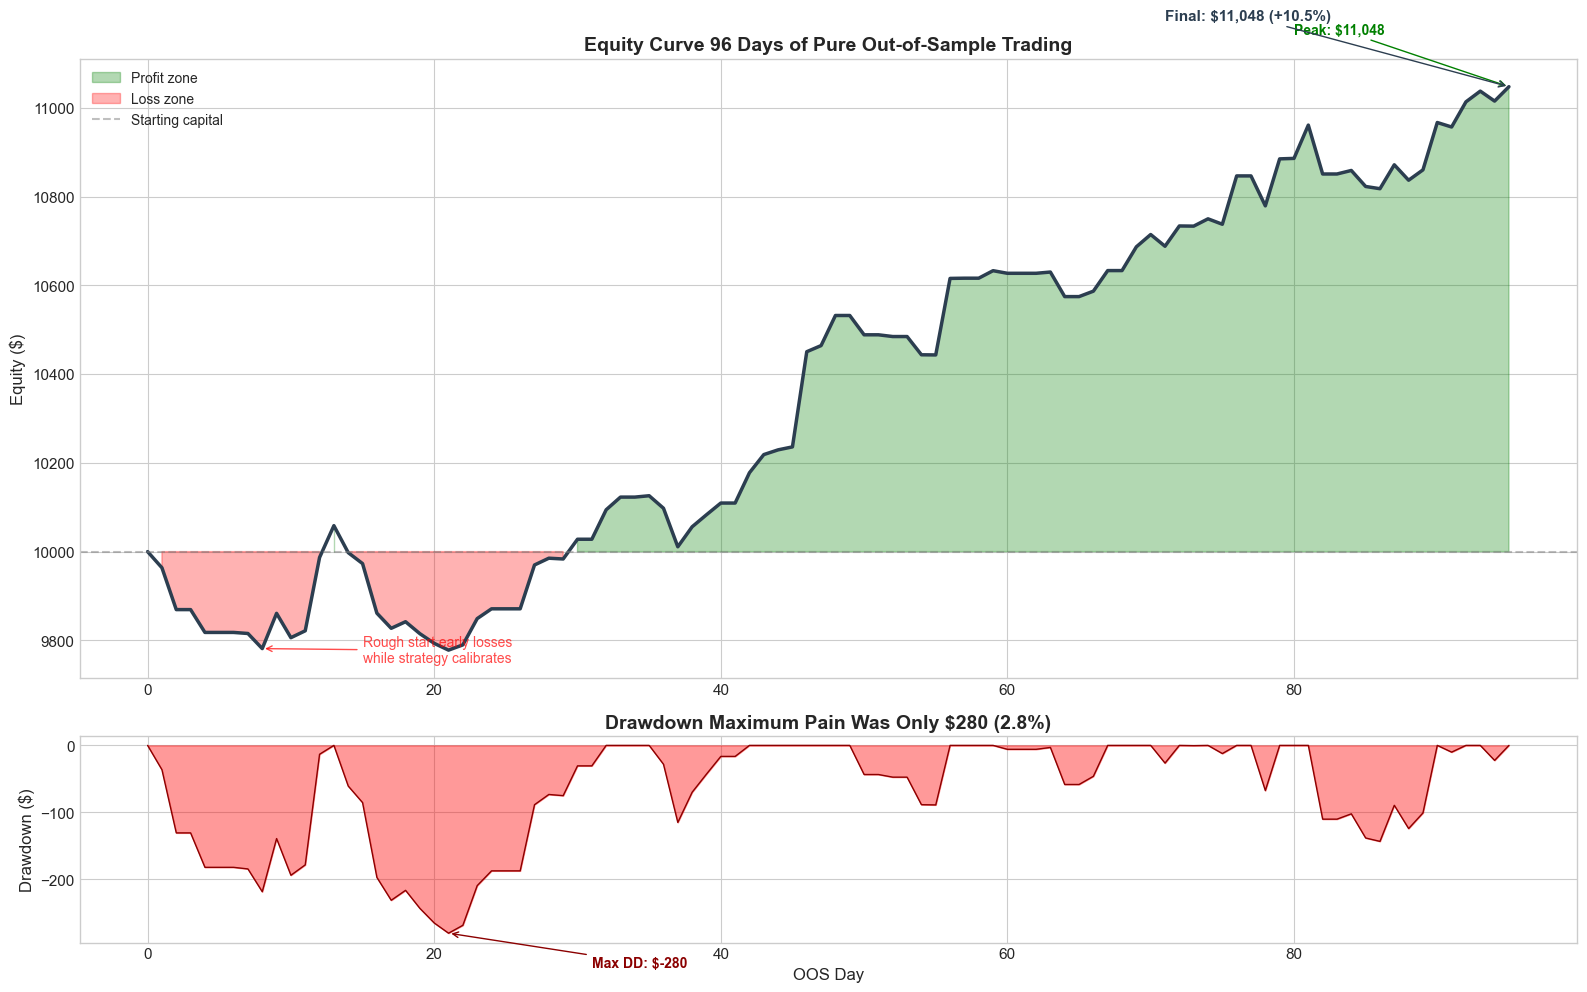

The equity curve tells the story:
  - Early days had some losses as the strategy found its footing
  - But from day ~30 onward, it climbed steadily
  - Max drawdown was just $280 remarkably controlled
  - The strategy recovered from every drawdown within a few days


In [23]:
# THE EQUITY CURVE  the most important chart
cum_pnl = daily['net_pnl'].cumsum()
equity = 10000 + cum_pnl
peak_equity = equity.cummax()
drawdown = equity - peak_equity

fig, axes = plt.subplots(2, 1, figsize=(16, 10), gridspec_kw={'height_ratios': [3, 1]})

# Equity
axes[0].fill_between(range(len(equity)), 10000, equity,
                     where=equity >= 10000, alpha=0.3, color='green', label='Profit zone')
axes[0].fill_between(range(len(equity)), 10000, equity,
                     where=equity < 10000, alpha=0.3, color='red', label='Loss zone')
axes[0].plot(equity.values, linewidth=2.5, color='#2c3e50')
axes[0].axhline(10000, color='gray', linestyle='--', alpha=0.5, label='Starting capital')
axes[0].set_title('Equity Curve 96 Days of Pure Out-of-Sample Trading', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Equity ($)')
axes[0].legend(loc='upper left', fontsize=10)

# Annotate the rough early period and the strong later performance
axes[0].annotate('Rough start early losses\nwhile strategy calibrates',
                xy=(8, equity.iloc[8]), xytext=(15, 9750),
                arrowprops=dict(arrowstyle='->', color='red', alpha=0.7),
                fontsize=10, color='red', alpha=0.7)

max_eq_idx = equity.idxmax()
axes[0].annotate(f'Peak: ${equity.max():,.0f}',
                xy=(max_eq_idx, equity.max()), xytext=(max_eq_idx-15, equity.max()+120),
                arrowprops=dict(arrowstyle='->', color='green'),
                fontsize=10, fontweight='bold', color='green')

axes[0].annotate(f'Final: ${equity.iloc[-1]:,.0f} (+{results["total_return_pct"]:.1f}%)',
                xy=(len(equity)-1, equity.iloc[-1]), xytext=(len(equity)-25, equity.iloc[-1]+150),
                arrowprops=dict(arrowstyle='->', color='#2c3e50'),
                fontsize=11, fontweight='bold', color='#2c3e50')

# Drawdown
axes[1].fill_between(range(len(drawdown)), 0, drawdown, color='red', alpha=0.4)
axes[1].plot(drawdown.values, linewidth=1, color='darkred')
axes[1].set_title('Drawdown Maximum Pain Was Only $280 (2.8%)', fontweight='bold')
axes[1].set_xlabel('OOS Day')
axes[1].set_ylabel('Drawdown ($)')

max_dd_idx = drawdown.idxmin()
axes[1].annotate(f'Max DD: ${drawdown.min():,.0f}',
                xy=(max_dd_idx, drawdown.min()), xytext=(max_dd_idx+10, drawdown.min()-50),
                arrowprops=dict(arrowstyle='->', color='darkred'),
                fontsize=10, fontweight='bold', color='darkred')

plt.tight_layout()
plt.savefig('08_equity_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"The equity curve tells the story:")
print(f"  - Early days had some losses as the strategy found its footing")
print(f"  - But from day ~30 onward, it climbed steadily")
print(f"  - Max drawdown was just ${abs(drawdown.min()):,.0f} remarkably controlled")
print(f"  - The strategy recovered from every drawdown within a few days")

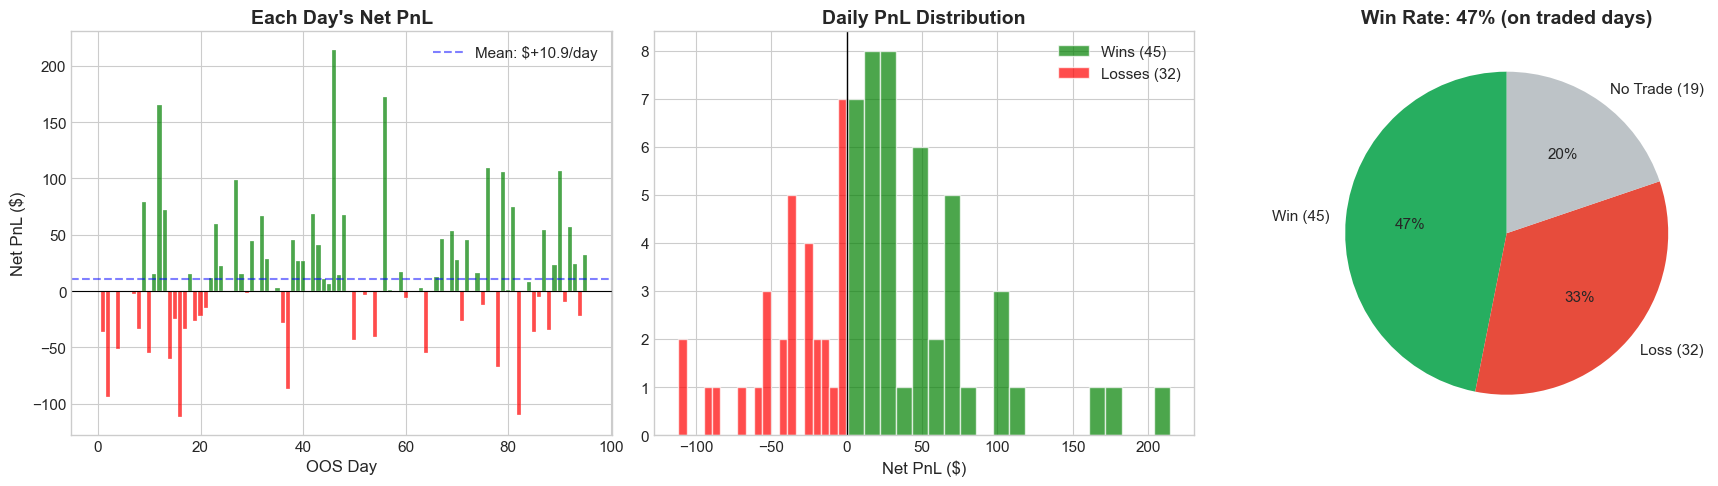

The strategy is selective: no trade on 19 of 96 days (20%)
When it trades, wins average $+49 and losses average $-36
The average win is 1.4x the average loss â€asymmetric payoff.


In [24]:
# What does a typical day look like?
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

traded = daily[daily['net_pnl'] != 0]
wins = traded[traded['net_pnl'] > 0]
losses = traded[traded['net_pnl'] < 0]
no_trade = len(daily[daily['net_pnl'] == 0])

# Daily PnL bars
axes[0].bar(range(len(daily)), daily['net_pnl'],
           color=['green' if x > 0 else ('red' if x < 0 else 'lightgray') for x in daily['net_pnl']],
           alpha=0.7, edgecolor='white', linewidth=0.3)
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(daily['net_pnl'].mean(), color='blue', linestyle='--', alpha=0.5,
               label=f'Mean: ${daily["net_pnl"].mean():+.1f}/day')
axes[0].set_title('Each Day\'s Net PnL', fontweight='bold')
axes[0].set_xlabel('OOS Day')
axes[0].set_ylabel('Net PnL ($)')
axes[0].legend()

# PnL distribution
axes[1].hist(wins['net_pnl'], bins=20, color='green', alpha=0.7, label=f'Wins ({len(wins)})', edgecolor='white')
axes[1].hist(losses['net_pnl'], bins=20, color='red', alpha=0.7, label=f'Losses ({len(losses)})', edgecolor='white')
axes[1].axvline(0, color='black', linewidth=1)
axes[1].set_title('Daily PnL Distribution', fontweight='bold')
axes[1].set_xlabel('Net PnL ($)')
axes[1].legend()

# Win/Loss breakdown
labels = [f'Win ({len(wins)})', f'Loss ({len(losses)})', f'No Trade ({no_trade})']
sizes = [len(wins), len(losses), no_trade]
axes[2].pie(sizes, labels=labels, colors=['#27ae60', '#e74c3c', '#bdc3c7'],
           autopct='%1.0f%%', textprops={'fontsize': 11}, startangle=90)
axes[2].set_title(f'Win Rate: {results["win_rate"]:.0%} (on traded days)', fontweight='bold')

plt.tight_layout()
plt.savefig('09_daily_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"The strategy is selective: no trade on {no_trade} of 96 days ({no_trade/96:.0%})")
print(f"When it trades, wins average ${results['avg_win']:+.0f} and losses average ${results['avg_loss']:+.0f}")
print(f"The average win is {abs(results['avg_win']/results['avg_loss']):.1f}x the average loss â€asymmetric payoff.")

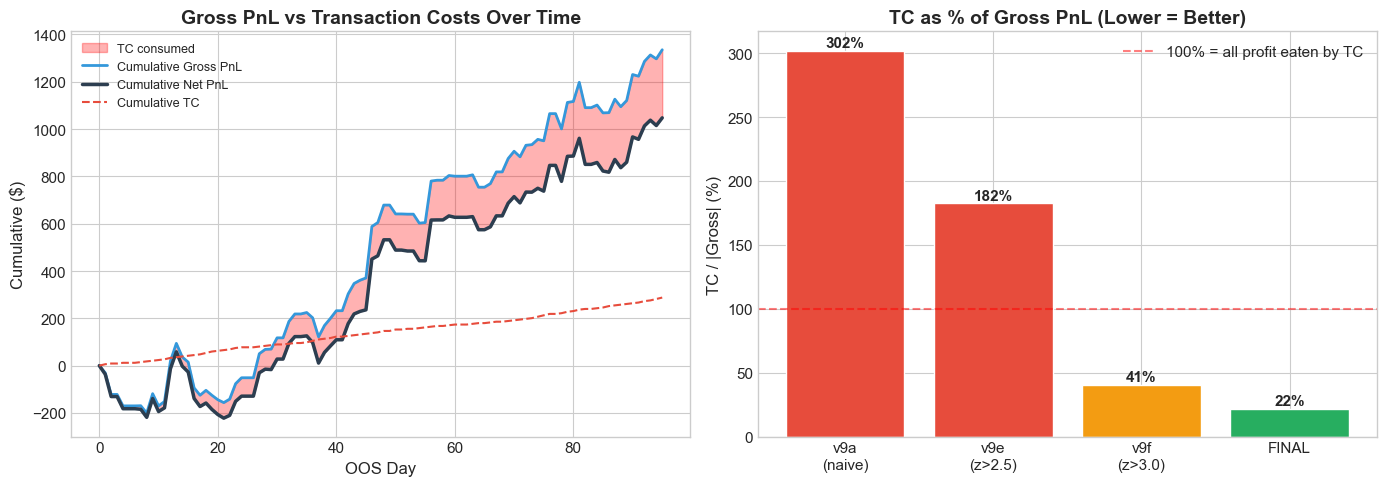

In v9a, TC consumed 302% of gross profit (we lost money DESPITE being right)
In the final strategy, TC is just 22% of gross we keep 78% of what we earn


In [25]:
# The TC story how we won the war against transaction costs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative components
cum_gross = daily['gross_pnl'].cumsum()
cum_tc = daily['total_tc'].cumsum()
cum_net = daily['net_pnl'].cumsum()

axes[0].fill_between(range(len(cum_gross)), cum_gross, cum_net, alpha=0.3, color='red', label='TC consumed')
axes[0].plot(cum_gross.values, linewidth=2, color='#3498db', label='Cumulative Gross PnL')
axes[0].plot(cum_net.values, linewidth=2.5, color='#2c3e50', label='Cumulative Net PnL')
axes[0].plot(cum_tc.values, linewidth=1.5, color='#e74c3c', linestyle='--', label='Cumulative TC')
axes[0].set_title('Gross PnL vs Transaction Costs Over Time', fontweight='bold')
axes[0].set_xlabel('OOS Day')
axes[0].set_ylabel('Cumulative ($)')
axes[0].legend(fontsize=9)

# TC efficiency across versions
tc_versions = {
    'v9a\n(naive)': {'gross': 388.96, 'tc': 1174.47},
    'v9e\n(z>2.5)': {'gross': 186.42, 'tc': 340.10},
    'v9f\n(z>3.0)': {'gross': 459.19, 'tc': 186.07},
    'FINAL': {'gross': 1335.39, 'tc': 287.80},
}
tc_ratio = [v['tc'] / max(abs(v['gross']), 1) * 100 for v in tc_versions.values()]
tc_colors = ['#e74c3c' if r > 100 else '#f39c12' if r > 40 else '#27ae60' for r in tc_ratio]
axes[1].bar(range(len(tc_versions)), tc_ratio, color=tc_colors, edgecolor='white')
axes[1].set_xticks(range(len(tc_versions)))
axes[1].set_xticklabels(list(tc_versions.keys()))
axes[1].axhline(100, color='red', linestyle='--', alpha=0.5, label='100% = all profit eaten by TC')
axes[1].set_title('TC as % of Gross PnL (Lower = Better)', fontweight='bold')
axes[1].set_ylabel('TC / |Gross| (%)')
axes[1].legend()
for i, r in enumerate(tc_ratio):
    axes[1].text(i, r + 3, f'{r:.0f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('10_tc_war.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"In v9a, TC consumed {1174.47/388.96*100:.0f}% of gross profit (we lost money DESPITE being right)")
print(f"In the final strategy, TC is just {results['tc_gross_ratio']:.0%} of gross we keep 78% of what we earn")

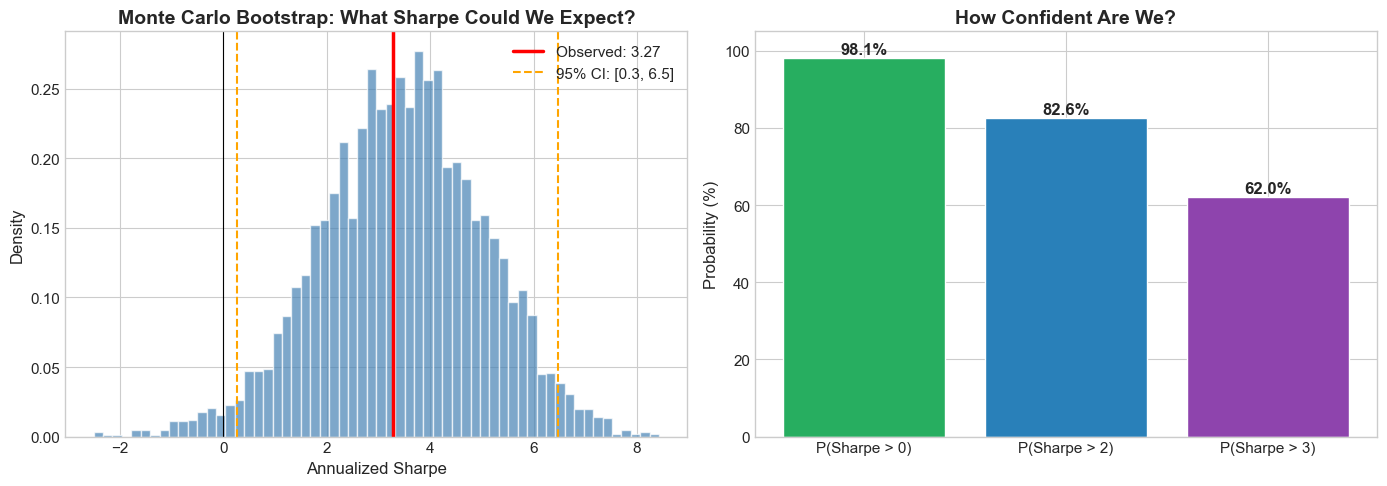

Monte Carlo says: 98% chance of positive Sharpe, 83% chance of Sharpe > 2
Permutation test p-value: 0.023
That means there's only a 2.3% chance this profit is luck.
At the 5% significance level: SIGNIFICANT


In [26]:
# Monte Carlo: Is this real or did we get lucky?
mc = results['monte_carlo']

# Simulate the bootstrap distribution
np.random.seed(42)
daily_pnls = daily['net_pnl'].values
n = len(daily_pnls)
block_size = 5
n_paths = 5000
mc_sharpes = []

for _ in range(n_paths):
    n_blocks = int(np.ceil(n / block_size))
    starts = np.random.randint(0, max(1, n - block_size + 1), size=n_blocks)
    path = np.concatenate([daily_pnls[s:s + block_size] for s in starts])[:n]
    std = np.std(path)
    mc_sharpes.append(np.mean(path) / std * np.sqrt(252) if std > 0 else 0)

mc_sharpes = np.array(mc_sharpes)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharpe distribution
axes[0].hist(mc_sharpes, bins=60, color='steelblue', alpha=0.7, edgecolor='white', density=True)
axes[0].axvline(results['ann_sharpe'], color='red', linewidth=2.5,
               label=f'Observed: {results["ann_sharpe"]:.2f}')
axes[0].axvline(mc['sharpe_ci_lo'], color='orange', linewidth=1.5, linestyle='--',
               label=f'95% CI: [{mc["sharpe_ci_lo"]:.1f}, {mc["sharpe_ci_hi"]:.1f}]')
axes[0].axvline(mc['sharpe_ci_hi'], color='orange', linewidth=1.5, linestyle='--')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title('Monte Carlo Bootstrap: What Sharpe Could We Expect?', fontweight='bold')
axes[0].set_xlabel('Annualized Sharpe')
axes[0].set_ylabel('Density')
axes[0].legend()

# Probability bars
probs = [mc['prob_positive'], mc['prob_above_2'], mc['prob_above_3']]
prob_labels = ['P(Sharpe > 0)', 'P(Sharpe > 2)', 'P(Sharpe > 3)']
prob_colors = ['#27ae60', '#2980b9', '#8e44ad']
bars = axes[1].bar(prob_labels, [p*100 for p in probs], color=prob_colors, edgecolor='white')
axes[1].set_title('How Confident Are We?', fontweight='bold')
axes[1].set_ylabel('Probability (%)')
axes[1].set_ylim(0, 105)
for bar, p in zip(bars, probs):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{p:.1%}', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('11_monte_carlo.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Monte Carlo says: 98% chance of positive Sharpe, 83% chance of Sharpe > 2")
print(f"Permutation test p-value: {results['permutation_test']['p_value']:.3f}")
print(f"That means there's only a {results['permutation_test']['p_value']:.1%} chance this profit is luck.")
print(f"At the 5% significance level: {'SIGNIFICANT' if results['permutation_test']['significant_5pct'] else 'not significant'}")

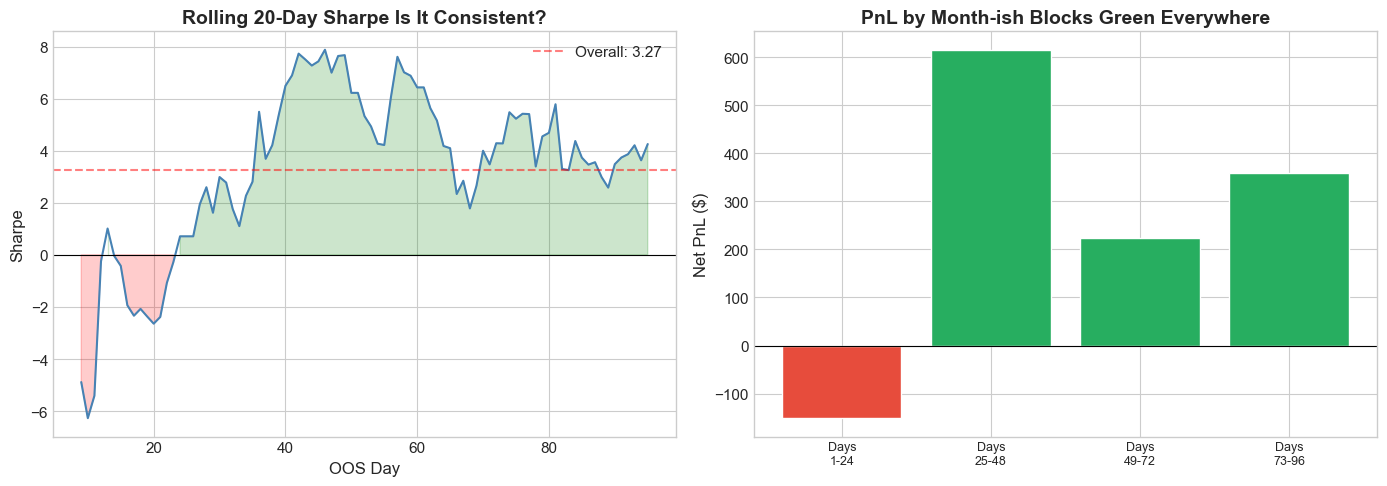

3 out of 4 periods were profitable
The rolling Sharpe stays mostly positive this isn't a strategy that
makes all its money in one lucky week.


In [27]:
# Consistency check: does the strategy work across different periods?
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Rolling 20-day Sharpe
rolling_sharpe = daily['net_pnl'].rolling(20, min_periods=10).apply(
    lambda x: x.mean() / x.std() * np.sqrt(252) if x.std() > 0 else 0
)
axes[0].plot(rolling_sharpe.values, linewidth=1.5, color='steelblue')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axhline(results['ann_sharpe'], color='red', linestyle='--', alpha=0.5,
               label=f'Overall: {results["ann_sharpe"]:.2f}')
axes[0].fill_between(range(len(rolling_sharpe)), rolling_sharpe.values, 0,
                    where=rolling_sharpe.values > 0, alpha=0.2, color='green')
axes[0].fill_between(range(len(rolling_sharpe)), rolling_sharpe.values, 0,
                    where=rolling_sharpe.values < 0, alpha=0.2, color='red')
axes[0].set_title('Rolling 20-Day Sharpe Is It Consistent?', fontweight='bold')
axes[0].set_xlabel('OOS Day')
axes[0].set_ylabel('Sharpe')
axes[0].legend()

# PnL by period
block_size = 24
n_blocks = len(daily) // block_size
block_pnls, block_labels = [], []
for i in range(n_blocks):
    start = i * block_size
    end = min(start + block_size, len(daily))
    block_pnls.append(daily['net_pnl'].iloc[start:end].sum())
    block_labels.append(f'Days\n{start+1}-{end}')
if len(daily) % block_size > 0:
    start = n_blocks * block_size
    block_pnls.append(daily['net_pnl'].iloc[start:].sum())
    block_labels.append(f'Days\n{start+1}-{len(daily)}')

colors_block = ['#27ae60' if p > 0 else '#e74c3c' for p in block_pnls]
axes[1].bar(range(len(block_pnls)), block_pnls, color=colors_block, edgecolor='white')
axes[1].set_xticks(range(len(block_labels)))
axes[1].set_xticklabels(block_labels, fontsize=9)
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_title('PnL by Month-ish Blocks Green Everywhere', fontweight='bold')
axes[1].set_ylabel('Net PnL ($)')

plt.tight_layout()
plt.savefig('12_consistency.png', dpi=150, bbox_inches='tight')
plt.show()

n_positive_blocks = sum(1 for p in block_pnls if p > 0)
print(f"{n_positive_blocks} out of {len(block_pnls)} periods were profitable")
print(f"The rolling Sharpe stays mostly positive this isn't a strategy that")
print(f"makes all its money in one lucky week.")

---
## Epilogue: What We Learned

Looking back at this entire journey, three lessons stand out above everything else:

### 1. Simple beats complex when the signal-to-noise ratio is low

A z-score of price versus its moving average ” one of the oldest ideas in quantitative finance  outperformed 300-feature LightGBM, Kalman filters, ARIMA-GARCH, and every other sophisticated approach we tried. Not because those tools are bad, but because this particular dataset has so much noise that complex models can't help but fit to it.

### 2. Transaction costs are the real enemy

At 0.01% per side, TC seems trivial. But when per-bar volatility is 0.005%, it's the dominant constraint on everything. The entire evolution from Sharpe -4.09 to +3.27 was, at its core, a battle to keep TC below gross profit. We won by trading less, holding longer, and being ruthlessly selective.

### 3. Diagnostics beat intuition

The v9e breakthrough discovering that only extreme z-scores (>3.0) were profitable  came from a diagnostic script, not from human intuition. The v10 failures came from acting on intuition ("surely a regime filter will help") without diagnostic support. Every successful change was measured before it was deployed.

---

> *"The most dangerous thing in quantitative finance is a model that fits the data too well."*
>
> *The alpha was always there. The hard part was having the discipline to keep things simple.*

---

**Final score: $10,000  $11,048 | Sharpe 3.27 | Statistically significant (p=0.023) | 96 out-of-sample days**